# Local Wikidata Agent 1
A conversational agent using a locally hosted LLM and a purpose-built LangChain ReAct agent that can query Wikidata for up-to-date facts and incorporate them into generated responses.

- accesses data via the Wikidata SPARQL endpoint to support inference 
- supports return of implicit facts in the dataset not explicitly on individual records
- defines a narrow scope of functionality in order to deal with the wide ranging schema of Wikidata content

This exercise builds on the `local-wikidata-agent-0.ipynb` exercise and adds iterates on the basic tool-calling agent architecture to try to help the model identify the relevant query parameters that will return a reasonably narrow set of facts that it can generate a correct answer. 

Sample questions (and correct responses) are provided below. Additional questions can be verified with [this SPARQL query](https://query.wikidata.org/#%23title%3A%2010%20youngest%20medalists%20of%20the%202024%20Summer%20Olympic%20Games%0A%23description%3A%20Return%20their%20country%2C%20sport%2C%20event%2C%20age%20at%20the%20time%20of%20the%20games%2C%20and%20medal%0APREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0APREFIX%20p%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APREFIX%20ps%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fstatement%2F%3E%0APREFIX%20pq%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fqualifier%2F%3E%0A%0A%0ASELECT%20DISTINCT%20%3FsportLabel%20%3FeventLabel%20%3FparticipantLabel%20%3Fage%20%3FcountryLabel%20%3FawardLabel%0A%0AWHERE%20%7B%0A%20%20%3Fsport%20wdt%3AP31%20wd%3AQ26132862%3B%20%20%23%20item%20that%20is%20an%20instance%20of%20olympic%20sports%20discipline%0A%20%20%20%20wdt%3AP361%2B%20wd%3AQ995653%3B%20%20%20%20%20%20%20%23%20and%20part%20of%202024%20games%2C%20or%20part%20of%20an%20event%20that%20was%0A%20%20%20%20wdt%3AP527%20%3Fevent.%20%20%20%20%20%20%20%20%20%20%20%20%23%20and%20hasParts%20that%20are%20individual%20events%0A%20%20%20%20%23%20not%20all%20disciplines%20have%20events%20listed%3B%20this%20list%20will%20be%20missing%20some%20categories%0A%20%20%0A%20%20%23%20get%20full%20statements%20about%20the%20participatns%2C%20participating%20teams%2C%20and%20winners%20of%20those%20events%0A%20%20%3Fevent%20p%3AP710%20%7C%20p%3AP1923%20%7C%20p%3AP1346%20%3FparticipantStatement.%0A%0A%20%20%3FparticipantStatement%20ps%3AP1346%20%7C%20ps%3AP710%20%7C%20ps%3AP1923%20%3Fparticipant%3B%20%20%23%20get%20the%20participant%0A%20%20%20%20%20%20pq%3AP166%20%7C%20pq%3AP2868%20%3Faward.%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23%20and%20that%20participant%27s%20award%0A%0A%20%20%3Fparticipant%20wdt%3AP1532%20%3Fcountry%3B%20%20%20%23%20Get%20the%20country%20the%20participant%20competed%20for%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP569%20%3Fdob.%20%20%20%20%20%20%20%20%23%20and%20their%20date%20of%20birth%0A%0A%20%20%23%20Bind%20closing%20ceremony%20date%20as%20%3Fclosing%0A%20%20BIND%28%222024-08-11%22%5E%5Exsd%3Adate%20AS%20%3Fclosing%29%0A%0A%20%20%23%20Calculate%20approximate%20age%20by%20subtracting%20the%20closing%20date%20from%20the%20participant%27s%20date%20of%20birth%0A%20%20BIND%28%0A%20%20%20%20FLOOR%28%0A%20%20%20%20%20%20%28YEAR%28%3Fclosing%29%20-%20YEAR%28%3Fdob%29%29%20-%0A%20%20%20%20%20%20%20%20IF%20%28MONTH%28%3Fclosing%29%20%3C%20MONTH%28%3Fdob%29%20%7C%7C%20%28MONTH%28%3Fclosing%29%20%3D%20MONTH%28%3Fdob%29%20%26%26%20DAY%28%3Fclosing%29%20%3C%20DAY%28%3Fdob%29%29%2C%201%2C%200%29%0A%20%20%20%20%29%20AS%20%3Fage%29%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%20%20%23%20Use%20SERVICE%20wikibase%3Alabel%20to%20fetch%20labels%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22.%20%7D%0A%7D%0AORDER%20BY%20%3Fage%0A%23%20LIMIT%2010%0A). 

## Observations
Narrowing the scope of "facet agents" did little to improve the quality or consistency of SPARQL queries generated. 

- different agents did not limit their use of parameters to those "allowed" in the instructions
- agents did sometime set parameters appropriately to generate the right data (for example for countries), but this is inconsistent, and not working as intended in the design 
- overall, this design approach did not simplifying the decision process usefully &mdash; or at all

## Takeaways
- Direct access to a "tool" with more than one parameter may not be feasible for local models &mdash; or even hosted models (the parameter count of the query was increased in this version in order to generate shorter response lists),
- The need for individual parameters is not easily teased out of natural languge questions. Consider forcing decisions about parameters one at a time. 


In [ ]:
# Instructions for downloading Ollama are at https://github.com/ollama/ollama

# %pip install langchain
# %pip install langchain_core
# %pip install langgraph
# %pip install sparqlwrapper
# %pip install -qU langchain_ollama

In [100]:
import os

# Enable tracing with LangSmith
# LANGCHAIN_API_KEY environment variable is set in .env
os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "agent-1"

# Set the USER_AGENT environment variable
os.environ['USER_AGENT'] = 'langgraph-agent'

## Define State

In [101]:
from typing import (Annotated, Sequence, TypedDict)
from langchain_core.messages import BaseMessage # Base abstract message class
from langgraph.graph.message import add_messages # Reducer. Merges two lists of messages, updating existing messages by ID.

class AgentState(TypedDict):
        messages: Annotated[Sequence[BaseMessage], add_messages]
        lookup_agent: str

## Create the Routing Agent

This agent will evaluate the user's question and delegate it to one of several specialized tools which are optimized to handle information discovery cases within a narrow purview.  

In [228]:
from langchain_core.messages import SystemMessage
from langchain_ollama import ChatOllama
import json

llm = ChatOllama(model="llama3.1:8b", temperature=0)

routing_agent_system = """You are an agent that works in coordination with other agents to generate responses from a knowledge graph. Your job is to route the human message query to the appropriate lookup agent who will in turn run a query. 

Choose between one of these four lookup agents: 

Event Agent: the Event Agent will formulate a query to the knowledge graph to find the kind of event that the human message is referring to. For example, if the human message is "Who was the youngest person to win the Badminton event at the 2024 Summer Olympics?" the Event Agent will query the knowledge graph to find all instances of the event "Badminton" in the dataset.  

Award Agent: the Award Agent will formulate a query to the knowledge graph to find the award that the human message is referring to. For example, if the human message is "Who was the youngest person to win a bronze medal at the 2024 Summer Olympics?" the Award Agent will query the knowledge graph to find all instances of "bronze medal" in the dataset.

Country Agent: the Country Agent will formulate a query to the knowledge graph to limit the results returned to those that contain the name of the Country you supply in this parameter. For example, if the human message is "Who was the oldest person to win a gold medal from Bolivia," the Country Agent will query the knowledge graph to find all instances of "Bolivia" in the dataset. 

Age Agent: the Age agent will formulate queries that focus on the age of participants at the time of the 2024 Summer Olympics. This agent is most effective when you need to return data about the oldest or youngest participants in the 2024 Summer Olympic games overall. 

Your job is to determine which agent to route the human message to. Respond with the agent's name in the "lookup_agent" key only. Do not include any other keys in the response and do not modify the human message.
""" 

def routing_agent(state: AgentState):
    system_prompt = SystemMessage(routing_agent_system)
    response = llm.invoke([system_prompt] + state["messages"])

    response_content = json.loads(response.content)
    lookup_agent = response_content.get("lookup_agent", "")

    return {"messages": [response], "lookup_agent": lookup_agent}


## Create Wikidata Lookup Tool and Tool Node

In [229]:
from SPARQLWrapper import SPARQLWrapper, JSON
from langchain.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import ToolNode

from typing import Literal


@tool
def wikidataOlympicMedalistQuery(
    direction: Literal["ASC", "DESC"] = "ASC",
    limit: int = 10,
    event: str = "",
    award: str = "",
    country: str = "",
) -> str:
    """This tool returns data on medal winners of the 2024 Summer Olympic Games from the Wikidata knowledge graph.
        It returns their country, sport, event, age at the time of the games, and what medal they won.
        By default it returns the 10 youngest medalists in ascending order of age.
        You can return a longer list of athletes by increasing the limit.
        You can change search for the oldest medalists first by changing the direction.
    Args:
        direction: The direction to sort the results.
        limit: The number of results to return.
        event: Limit results to events containing this keyword.
        award: Limit results to awards containing this keyword.
        country: Limit results to countries containing this keyword."""

    endpoint_url = "https://query.wikidata.org/sparql"

    query = f"""#title: 10 youngest medalists of the 2024 Summer Olympic Games
    #description: Return their country, sport, event, age at the time of the games, and medal
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>
    PREFIX p: <http://www.wikidata.org/prop/>
    PREFIX ps: <http://www.wikidata.org/prop/statement/>
    PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


    SELECT DISTINCT ?sportLabel ?eventLabel ?participantLabel ?age ?countryLabel ?awardLabel

    WHERE {{
    ?sport wdt:P31 wd:Q26132862;    # item that is an instance of olympic sports discipline
        wdt:P361+ wd:Q995653;       # and part of 2024 games, or part of an event that was
        wdt:P527 ?event.            # and hasParts that are individual events
                                    # not all disciplines have events listed: this list will be missing some categories

    # filter to events by English keyword
    ?event rdfs:label ?humanEventLabel.
    FILTER(LANG(?humanEventLabel) = "en").
    FILTER(CONTAINS(?humanEventLabel, "{event}")).


    # get full statements about the participants, participating teams, and winners of those events
    ?event p:P710 | p:P1923 | p:P1346 ?participantStatement.

    ?participantStatement ps:P1346 | ps:P710 | ps:P1923 ?participant;  # get the participant
        pq:P166 | pq:P2868 ?award.                                     # and that participant's award

    # Filter to award by English keyword
    ?award rdfs:label ?humanAwardLabel.
    FILTER(LANG(?humanAwardLabel) = "en").
    FILTER(CONTAINS(?humanAwardLabel, "{award}")).


    ?participant wdt:P1532 ?country;   # Get the country the participant competed for
                wdt:P569 ?dob.         # and their date of birth

    # Filter to country by English keyword
    ?country rdfs:label ?humanCountryLabel.
    FILTER(LANG(?humanCountryLabel) = "en").
    FILTER(CONTAINS(?humanCountryLabel, "{country}")).                

    # Bind closing ceremony date as ?closing
    BIND("2024-08-11"^^xsd:date AS ?closing)

    # Calculate approximate age by subtracting the closing date from the participant's date of birth
    BIND(
        FLOOR(
        (YEAR(?closing) - YEAR(?dob)) -
            IF (MONTH(?closing) < MONTH(?dob) || (MONTH(?closing) = MONTH(?dob) && DAY(?closing) < DAY(?dob)), 1, 0)
        ) AS ?age)
                
    # Use SERVICE wikibase:label to fetch labels
    SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    ORDER BY {direction}(?age)
    LIMIT {limit}
    """

    def get_results(endpoint_url, query):
        user_agent = "LlmIntegration/0.0 (https://github.com/andybywire/)"
        sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        return sparql.query().convert()

    results = get_results(endpoint_url, query)

    def create_statements(results):
        statements = []
        if results:
            for result in results["results"]["bindings"]:
                statement = f"{result['participantLabel']['value']}, age {result['age']['value']} from {result['countryLabel']['value']}, won a {result['awardLabel']['value'].replace('Olympic','')} in {result['eventLabel']['value'].replace(' – ',', ')}."
                statements.append(statement)
        return statements

    return create_statements(results)


tools = [wikidataOlympicMedalistQuery]

tool_node = ToolNode(tools)


## Define Facet Agents
Facet agents are given a limited scope of operation intended to help them focus on setting a subset of parameters targeted toward specific kinds of questions. 

In [230]:
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, PipelinePromptTemplate

introduction = "You are an assistant designed for answering questions about the results of the 2024 Summer Olympics. Use the 'WikiData Olympic Medalist' tool at your disposal to retrieve data in response to the human question about the 2024 Olympics. The data you retrieve will be passed to a subsequent agent for interpretation. Your job is only to define the correct arguments for the tool."

age_agent = """The tool allows you to easily find the youngest or oldest medalist in the dataset. You may ONLY use two parameters for the 'Wikidata Olympic Medalist' tool:

DIRECTION: The direction to sort the results by age. The default is ascending order, from youngest athlete to oldest. You can change the direction to "DESC" to sort the results in descending order, from oldest athlete to youngest. If you are looking for the oldest athlete in a category, you would set the direction parameter to "DESC" and use a lower limit to return only the most relevant results.

LIMIT: The number of results to return. The default is 10. If you must increase results, increase them in increments of 10. Do not increase the limit parameter unnecessarily, and do not in any case increase the return limit over 25 returned facts. There must never more than 25 results returned from the tool. DO NOT return large result sets by default, as these provide can more data than is needed and can make it harder to find the correct answer.

DO NOT use any other parameters associated with this tool or modify the human message. Do not return values for the AWARD, COUNTRY or EVENT arguments. These arguments will keep their default values and must be returned blank.
"""

award_agent = """The tool provides three parameters that you may use:

AWARD: Allows you to limit results to those about a specific Olympic medal, either gold, silver, or bronze. For example, if the human message is "Who was the youngest gold medalist in the 2024 Olympic games," you would set AWARD to gold in order to return a list of only gold medalists.

DIRECTION: The direction to sort the results by age. The default is ascending order, from youngest athlete to oldest. You can change the direction to "DESC" to sort the results in descending order, from oldest athlete to youngest. If you are looking for the oldest athlete in a category, you would set the direction parameter to "DESC" and use a lower limit to return only the most relevant results.

LIMIT: The number of results to return. The default is 10. If you must increase results, increase them in increments of 10. Do not increase the limit parameter unnecessarily, and do not in any case increase the return limit over 25 returned facts. There must never more than 25 results returned from the tool. DO NOT return large result sets by default, as these provide can more data than is needed and can make it harder to find the correct answer.

DO NOT use any other parameters associated with this tool or modify the human message. Do not return values for the COUNTRY or EVENT arguments. These will keep their default values. 
"""

country_agent = """The tool provided provides three parameters that you may use:

COUNTRY: Allows you to limit results to those about an athlete from a specific country. For example, if the human message is "Who was the oldest person to win a gold medal from Bolivia," you would set the COUNTRY parameter to "Bolivia" to return results from only that country. 

DIRECTION: The direction to sort the results by age. The default is ascending order, from youngest athlete to oldest. You can change the direction to "DESC" to sort the results in descending order, from oldest athlete to youngest. If you are looking for the oldest athlete in a category, you would set the direction parameter to "DESC" and use a lower limit to return only the most relevant results.

LIMIT: The number of results to return. The default is 10. If you must increase results, increase them in increments of 10. Do not increase the limit parameter unnecessarily, and do not in any case increase the return limit over 25 returned facts. There must never more than 25 results returned from the tool. DO NOT return large result sets by default, as these provide can more data than is needed and can make it harder to find the correct answer.

DO NOT use any other parameters associated with this tool or modify the human message. Do not return values for the AWARD or EVENT arguments. These will keep their default values. 
"""

event_agent = """The tool provided provides three parameters that you may use:

EVENT: Limits the results to events containing this keyword. For example, if the human message is "Who was the youngest person to win the Badminton event at the 2024 Summer Olympics?" you would set the event parameter to "Badminton".

DIRECTION: The direction to sort the results by age. The default is ascending order, from youngest athlete to oldest. You can change the direction to "DESC" to sort the results in descending order, from oldest athlete to youngest. If you are looking for the oldest athlete in a category, you would set the direction parameter to "DESC" and use a lower limit to return only the most relevant results.

LIMIT: The number of results to return. The default is 10. If you must increase results, increase them in increments of 10. Do not increase the limit parameter unnecessarily, and do not in any case increase the return limit over 25 returned facts. There must never more than 25 results returned from the tool. DO NOT return large result sets by default, as these provide can more data than is needed and can make it harder to find the correct answer.

DO NOT use any other parameters associated with this tool or modify the human message. Do not return values for the AWARD or COUNTRY arguments. These will keep their default values. 
"""

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "{introduction}\n\n{facet_agent}"),
        ("user", "{initial_query}")
     ]
)

class FacetAgent:
    def __init__(self, facet: str,):
        self.facet = facet

    def __call__(self, state: AgentState):
        initial_query = state["messages"][0].content

        facet_agent_chain = prompt_template | llm.bind_tools(tools)
        
        response = facet_agent_chain.invoke(
            {
                "introduction": introduction,
                "facet_agent": self.facet,
                "initial_query": initial_query,
            }
        )

        return {"messages": [response]}

## Create Response Agent

The response agent responds to the original user query in light of the facts provided by the query generated by the facet agent.

In [231]:
from langchain_core.messages import HumanMessage, SystemMessage
import json

response_agent_prompt = """You are an assistant designed for answering questions about the results of the 2024 Summer Olympics. Use the provided set of facts drawn from Wikidata to answer the Human question provided. The response data contains information about participant age, country of origin, the event in which they competed, and the award received. If the response to the User's question is not contained in the data, say that the provided data does not answer that question. Do NOT, under any circumstances, make up an answer or rely on outside knowledge. If you are not able to answer the question, say so, and also provide an interesting fact that is based on the data returned. Keep your answers concise and limit your responses to 3-4 sentences or brief lists.

Here are the facts you have to work with: 

{facts}
"""

response_agent_template = PromptTemplate.from_template(response_agent_prompt)


def response_agent(state: AgentState):
    # extract the tool response from state
    initial_query = state["messages"][0].content
    tool_response = state["messages"][-1].content

    # convert json string to a python list
    response_list = json.loads(tool_response)

    facts = "\n".join(response_list)

    system_prompt = response_agent_template.format(facts=facts)

    response = llm.invoke(state["messages"] + [SystemMessage(system_prompt)] + [HumanMessage(initial_query)])
    return {"messages": [response]}

## Define the Graph

In [232]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)

workflow.add_node("routing_agent", routing_agent)
workflow.add_node("event_agent", FacetAgent(event_agent))
workflow.add_node("award_agent", FacetAgent(award_agent))
workflow.add_node("country_agent", FacetAgent(country_agent))
workflow.add_node("age_agent", FacetAgent(age_agent))
workflow.add_node("response_agent", response_agent)
workflow.add_node("tool_node", tool_node)


def route_request(state: AgentState):
    if state["lookup_agent"] == "Age Agent":
        return "age_agent"
    elif state["lookup_agent"] == "Award Agent":
        return "award_agent"
    elif state["lookup_agent"] == "Country Agent":
        return "country_agent"
    elif state["lookup_agent"] == "Event Agent":
        return "event_agent"

workflow.add_conditional_edges(
    "routing_agent", 
    route_request,
    {
        "award_agent": "award_agent",
        "age_agent": "age_agent",
        "country_agent": "country_agent",
        "event_agent": "event_agent",
    }
  )

workflow.add_edge(START, "routing_agent")
workflow.add_edge("age_agent", "tool_node")
workflow.add_edge("award_agent", "tool_node")
workflow.add_edge("country_agent", "tool_node")
workflow.add_edge("event_agent", "tool_node")
workflow.add_edge("tool_node", "response_agent")
workflow.add_edge("response_agent", END)

graph = workflow.compile()

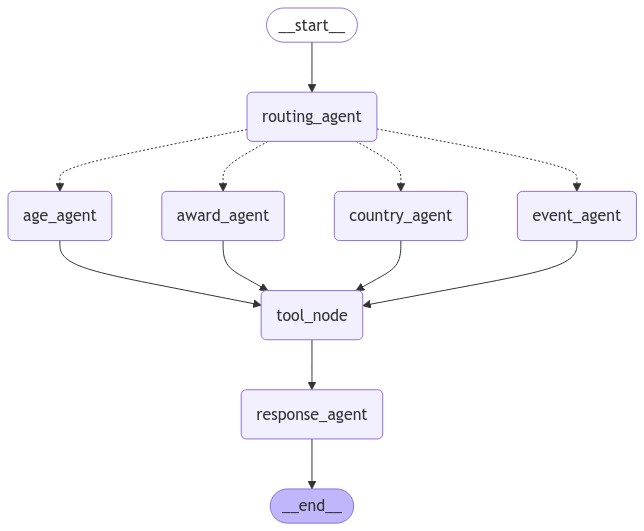

In [233]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [234]:
questions = [
"Who were the youngest medalists at the 2024 Summer Olympics and what did they win?",
"What countries were the youngest medalists at the 2024 Summer Olympics from?",
"Who was the youngest medalist from Japan in the 2024 Summer Olympic games?",
"What event in a the 2024 Summer Olympics did the youngest medalist from Spain win?",
"What medal in the 2024 Summer Olympics did the youngest medalist from Spain win?",
"Who was the oldest medalist at the 2024 Olympics from a country in Africa?",
"Who was the youngest fencing medalist at the 2024 Olympic Games?",
"Who was the oldest medalist in weightlifting at the 2024 Summer Olympics?",
]

events = graph.stream(
  {"messages": [("user", questions[2])]},
  stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

Who was the youngest medalist from Japan in the 2024 Summer Olympic games?
================================== Ai Message ==================================

{"lookup_agent": "Event Agent"}
================================== Ai Message ==================================
Tool Calls:
  wikidataOlympicMedalistQuery (fc932252-413f-4222-9358-3c5728f8af04)
 Call ID: fc932252-413f-4222-9358-3c5728f8af04
  Args:
    award: 
    country: Japan
    direction: ASC
    event: 
    limit: 1
================================= Tool Message =================================
Name: wikidataOlympicMedalistQuery

["Rikuto Tamai, age 17 from Japan, won a  silver medal in diving at the 2024 Summer Olympics, men's 10 metre platform."]
================================== Ai Message ==================================

The youngest medalist from Japan in the 2024 Summer Olympic games was Rikuto Tamai, who was 17 years old. He won a s